In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Libraries

In [4]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [5]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Rainfall/Rajshahi.csv')
#the daily dataset
print(df.shape)
df.head()

(20747, 2)


,DATE,Rainfall(mm)
0,5/1/1961,0.0
1,5/2/1961,0.0
2,5/3/1961,0.0
3,5/4/1961,0.0
4,5/5/1961,0.0


In [6]:
#checking types
df.dtypes

DATE             object
Rainfall(mm)    float64
dtype: object

Data Preprocessing
---------

In [7]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

            DATE  Rainfall(mm)
0       5/1/1961           0.0
1       5/2/1961           0.0
2       5/3/1961           0.0
3       5/4/1961           0.0
4       5/5/1961           0.0
...          ...           ...
20742  4/26/2019           0.0
20743  4/27/2019           0.0
20744  4/28/2019           0.0
20745  4/29/2019           0.0
20746  4/30/2019           0.0

[20747 rows x 2 columns]


In [8]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [9]:
df.head()

,DATE,Rainfall(mm)
0,5/1/1961,0.0
1,5/2/1961,0.0
2,5/3/1961,0.0
3,5/4/1961,0.0
4,5/5/1961,0.0


In [10]:
df.tail()

,DATE,Rainfall(mm)
20742,4/26/2019,0.0
20743,4/27/2019,0.0
20744,4/28/2019,0.0
20745,4/29/2019,0.0
20746,4/30/2019,0.0


In [11]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
df_pr.sort_values('DATE', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('DATE', inplace=True)
df_pr.head()

,Rainfall(mm)
DATE,
1/1/1962,0.0
1/1/1963,0.0
1/1/1964,0.0
1/1/1965,0.0
1/1/1966,0.0


In [12]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Rajshahi_monthly.csv")

(696, 1)


In [13]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1961-05-31 00:00:00
End Date: 2019-04-30 00:00:00
Total month: 696
Total year: 58


Data Visulalization
----------

About Data

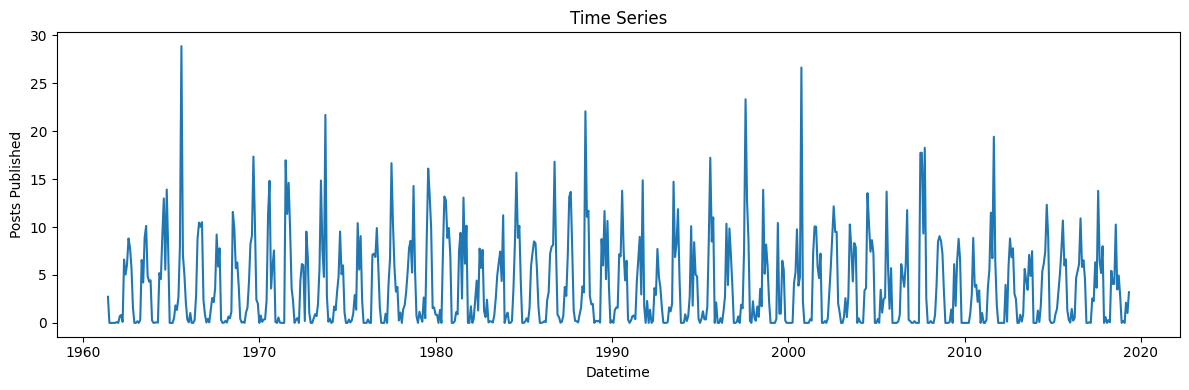

In [14]:
# 7.Plotting the time series
monthly['Rainfall(mm)'] = monthly['Rainfall(mm)'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(584, 1), Validation=(112, 1)


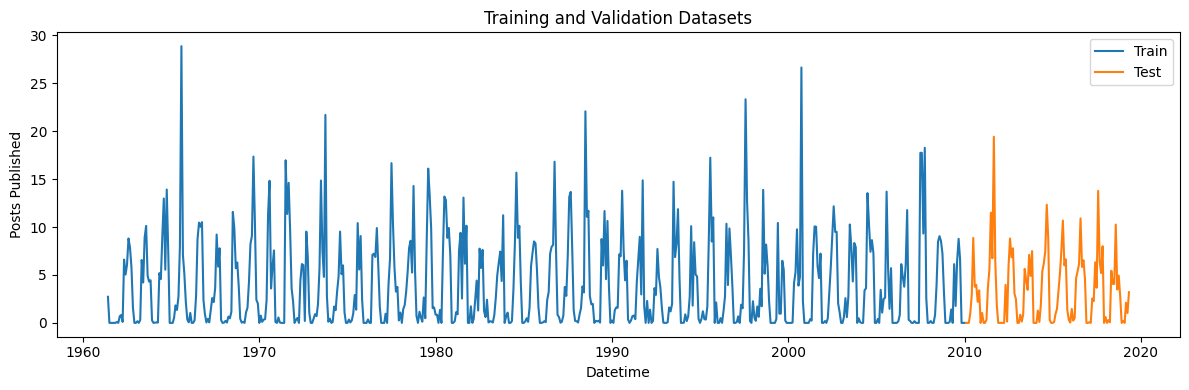

In [15]:
train = monthly.loc[:'2009-12-31']
valid = monthly.loc['2010-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [16]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [17]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

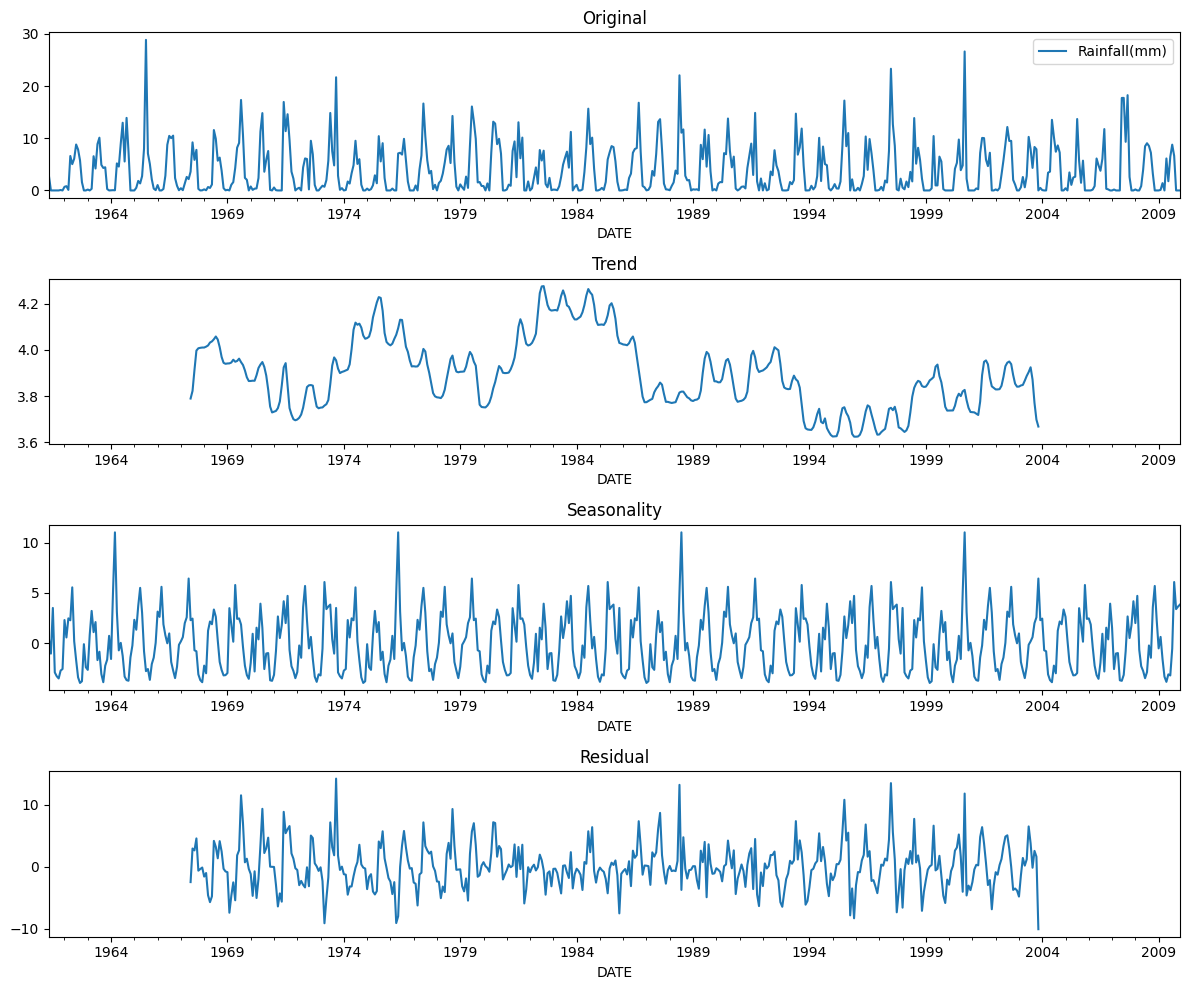

In [18]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [19]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

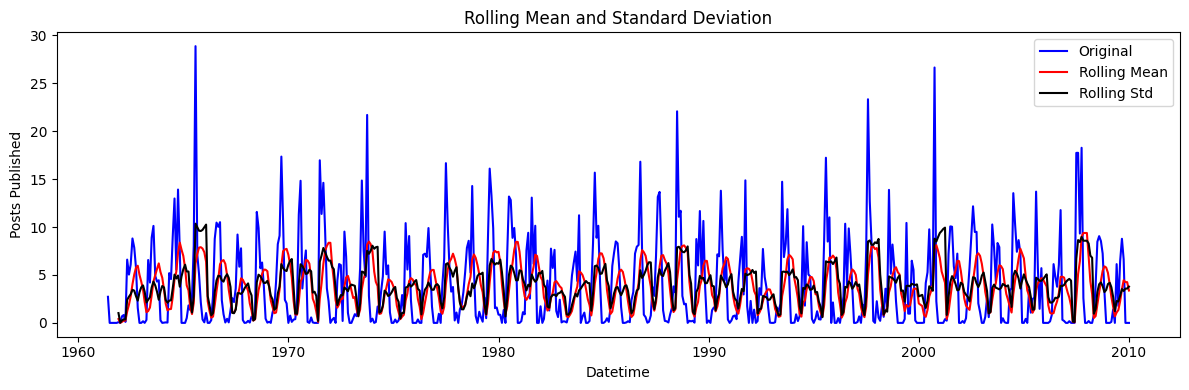

Results of Dickey-Fuller Test:
Test Statistic                -6.411348e+00
P-Value                        1.887440e-08
#Lags Used                     1.900000e+01
Number of Observations Used    5.640000e+02
Critical Value (1%)           -3.441998e+00
Critical Value (5%)           -2.866678e+00
Critical Value (10%)          -2.569506e+00
dtype: float64


In [20]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()

    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')

# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL

In [21]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [22]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Rainfall(mm)   No. Observations:                  584
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -1560.910
Date:                Thu, 20 Jul 2023   AIC                           3139.820
Time:                        09:58:54   BIC                           3179.133
Sample:                    05-31-1961   HQIC                          3155.143
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2557      0.036      7.201      0.000       0.186       0.325
ar.L2          0.0299      0.046      0.650      0.516      -0.060       0.120
ar.L3         -0.0299      0.042     -0.719      0.4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


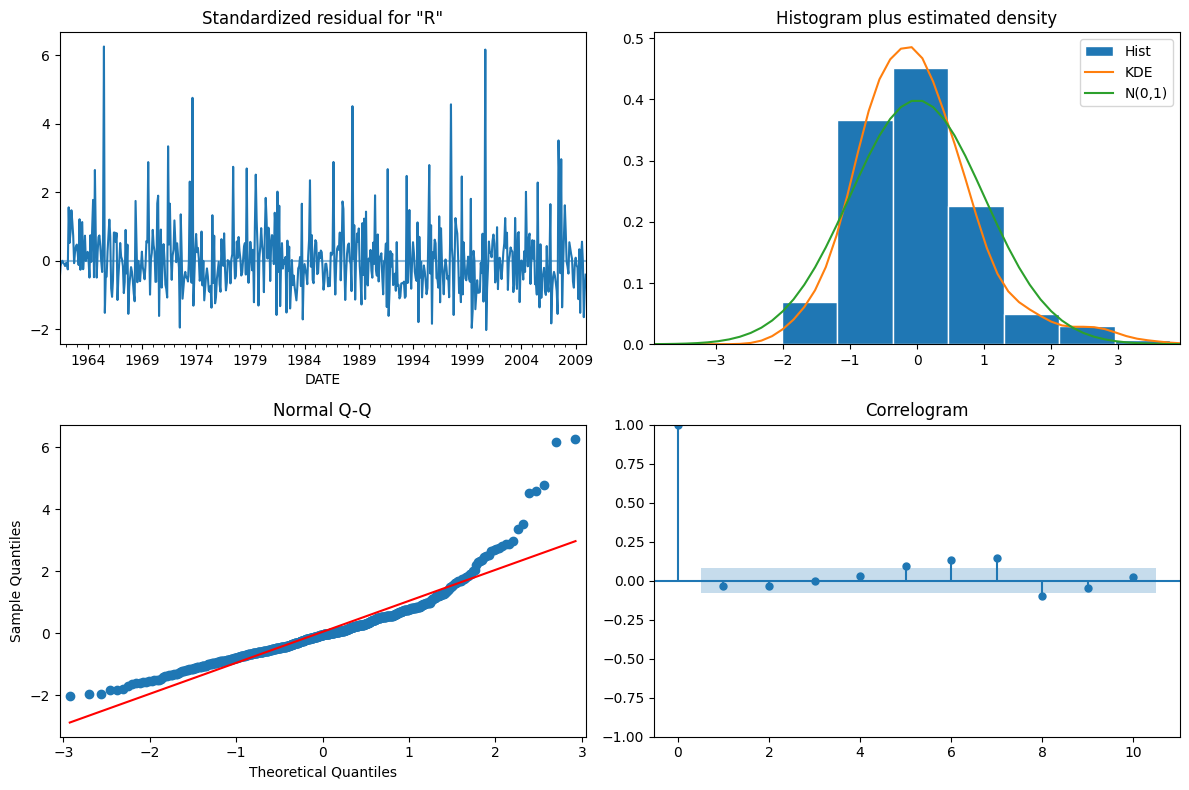

In [23]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

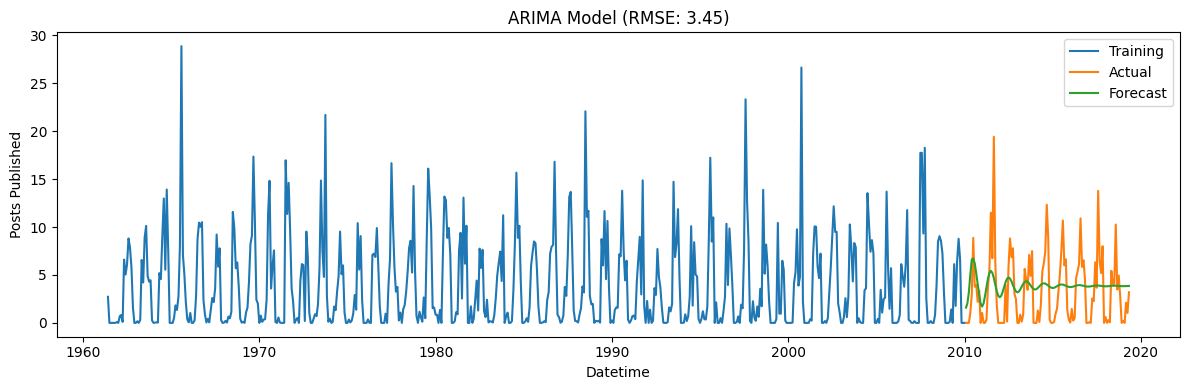

In [24]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [25]:
#Values of ARIMA prediction
print(forecast_arima)

2010-01-31    1.596799
2010-02-28    2.007269
2010-03-31    3.171696
2010-04-30    5.018501
2010-05-31    6.613736
                ...   
2018-12-31    3.831155
2019-01-31    3.832757
2019-02-28    3.839072
2019-03-31    3.848048
2019-04-30    3.857141
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [26]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  3.4521335898435175


---------------------

SARIMAX MODEL

In [27]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [28]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Rainfall(mm)   No. Observations:                  584
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood               -1440.819
Date:                            Thu, 20 Jul 2023   AIC                           2915.638
Time:                                    10:01:23   BIC                           2989.543
Sample:                                05-31-1961   HQIC                          2944.471
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0624      0.042      1.492      0.136      -0.020       0.144
ar.L2         -0.0123      0.043   

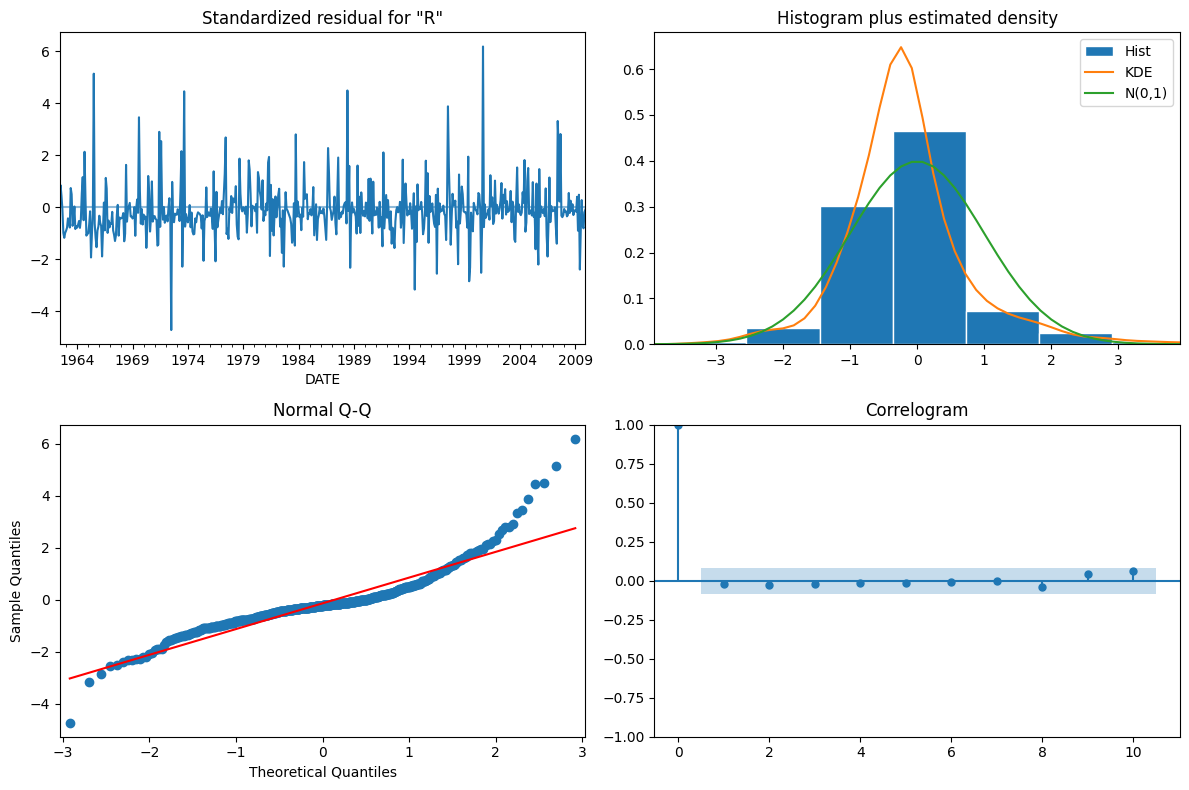

In [29]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

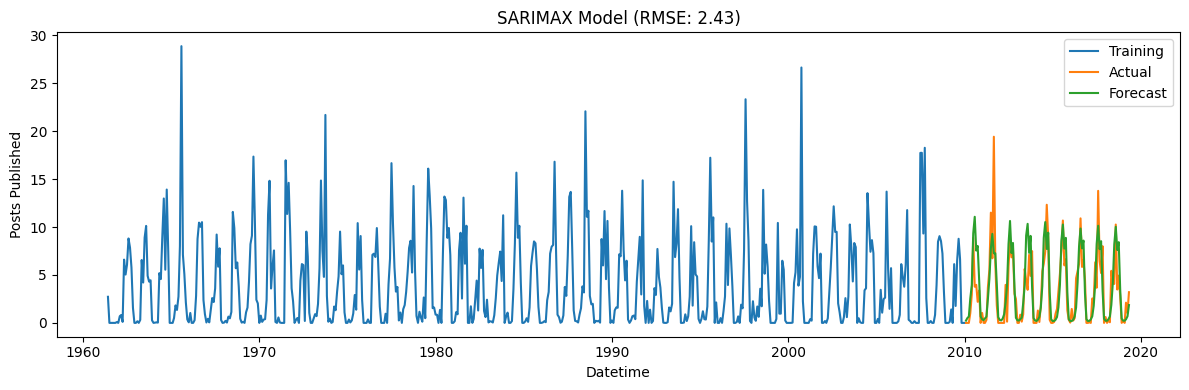

In [30]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [31]:
#Value of SARIMA prediction
print(forecast_sarimax)

2010-01-31    0.240117
2010-02-28    0.498348
2010-03-31    0.662418
2010-04-30    2.558085
2010-05-31    3.944345
                ...   
2018-12-31    0.233934
2019-01-31    0.223198
2019-02-28    0.371474
2019-03-31    0.690929
2019-04-30    1.859467
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [32]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  2.427187851881259


-----------------------

PROPHET

In [33]:
#Reading monthly data
df= pd.read_csv('Rajshahi_monthly.csv')

In [34]:
#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1961-05-31,2.722581
1,1961-06-30,NaN
2,1961-07-31,NaN
3,1961-08-31,NaN
4,1961-09-30,NaN


In [35]:
#prophet model Implement
prophet_model = Prophet()

In [36]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ip9s3zb/p4osf1qy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ip9s3zb/o_d1fn5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57177', 'data', 'file=/tmp/tmp3ip9s3zb/p4osf1qy.json', 'init=/tmp/tmp3ip9s3zb/o_d1fn5x.json', 'output', 'file=/tmp/tmp3ip9s3zb/prophet_modelb2v7r74u/prophet_model-20230720100127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:01:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:01:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [37]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 6, freq='M')
print(prophet_forecast_date)

            ds
0   1961-05-31
1   1961-06-30
2   1961-07-31
3   1961-08-31
4   1961-09-30
..         ...
763 2024-12-31
764 2025-01-31
765 2025-02-28
766 2025-03-31
767 2025-04-30

[768 rows x 1 columns]


In [38]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1961-05-31,4.148872,1.203764,8.102004,4.148872,4.148872,0.465532,0.465532,0.465532,0.465532,0.465532,0.465532,0.0,0.0,0.0,4.614404
1,1961-06-30,4.148140,5.016905,12.089669,4.148140,4.148140,4.393326,4.393326,4.393326,4.393326,4.393326,4.393326,0.0,0.0,0.0,8.541466
2,1961-07-31,4.147384,6.399341,13.926357,4.147384,4.147384,6.008583,6.008583,6.008583,6.008583,6.008583,6.008583,0.0,0.0,0.0,10.155967
3,1961-08-31,4.146628,4.546860,11.547892,4.146628,4.146628,3.777732,3.777732,3.777732,3.777732,3.777732,3.777732,0.0,0.0,0.0,7.924360
4,1961-09-30,4.145896,4.987470,11.896241,4.145896,4.145896,4.412712,4.412712,4.412712,4.412712,4.412712,4.412712,0.0,0.0,0.0,8.558608


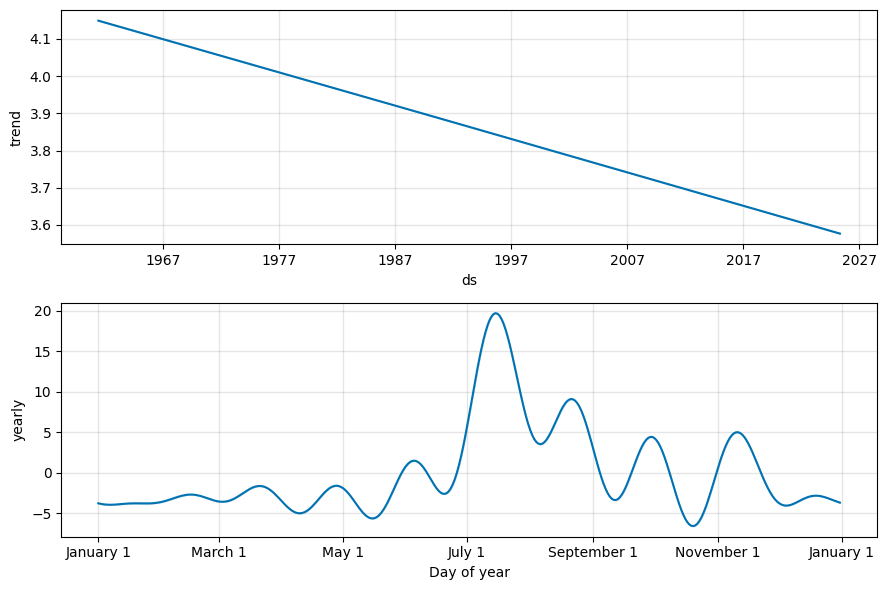

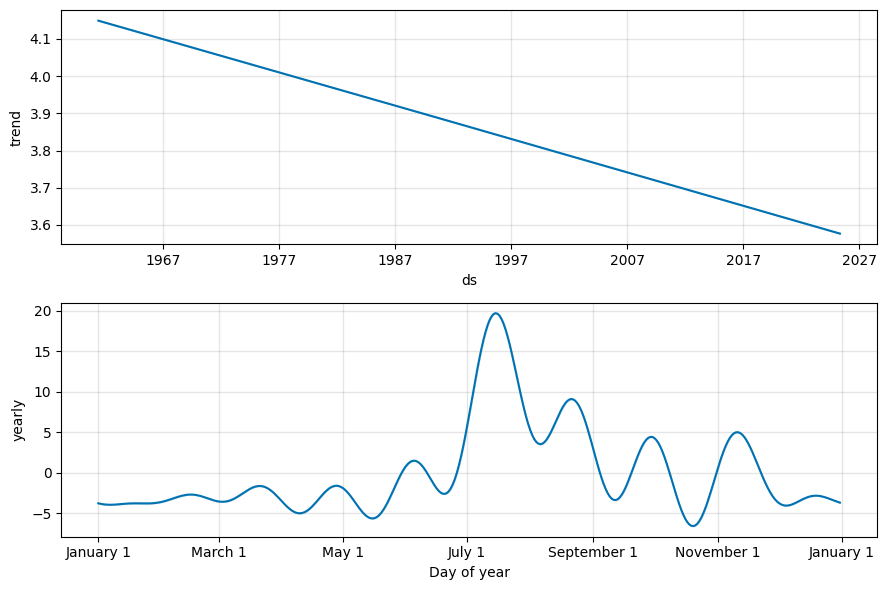

In [39]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [40]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe
fd=forecast_prophet_data.set_index('ds')
print(fd)

                 yhat
ds                   
1961-05-31   4.614404
1961-06-30   8.541466
1961-07-31  10.155967
1961-08-31   7.924360
1961-09-30   8.558608
...               ...
2024-12-31  -0.117932
2025-01-31  -0.071444
2025-02-28   0.085972
2025-03-31   0.348684
2025-04-30   1.842735

[768 rows x 1 columns]


In [41]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1961-05-31     4.614404
1961-06-30     8.541466
1961-07-31    10.155967
1961-08-31     7.924360
1961-09-30     8.558608
                ...    
2024-12-31    -0.117932
2025-01-31    -0.071444
2025-02-28     0.085972
2025-03-31     0.348684
2025-04-30     1.842735
Name: yhat, Length: 768, dtype: float64


In [42]:
forecast_prophet_valid=full_forecast_prophet['2010-01-31':'2019-04-30']

In [43]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  2.303063178680077


-----------------

MODEL Comparison
----------

Testing

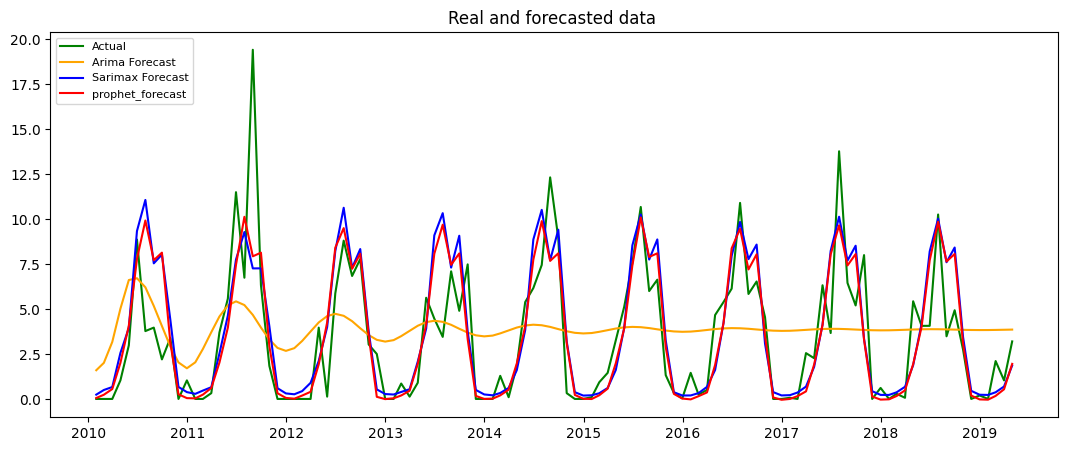

In [44]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

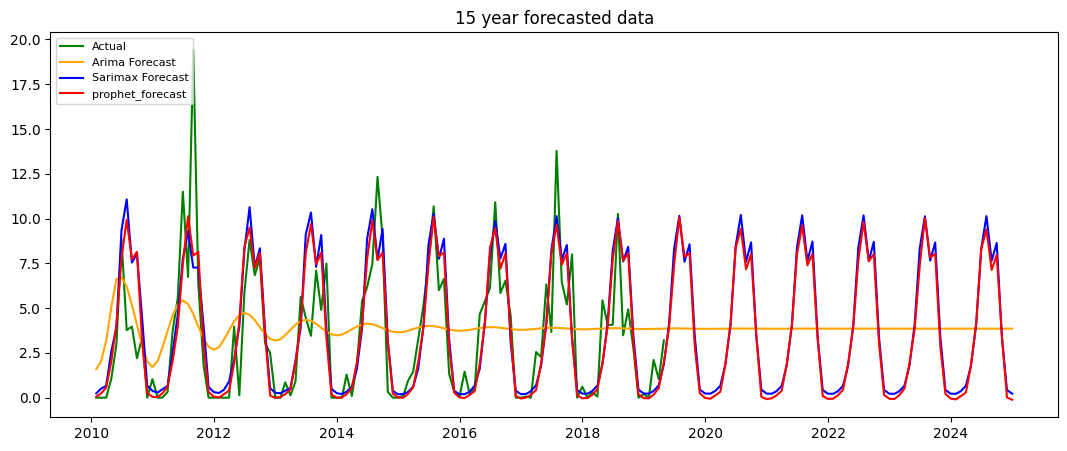

In [45]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+68)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+68)
forecast_10_prophet=full_forecast_prophet['2010-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

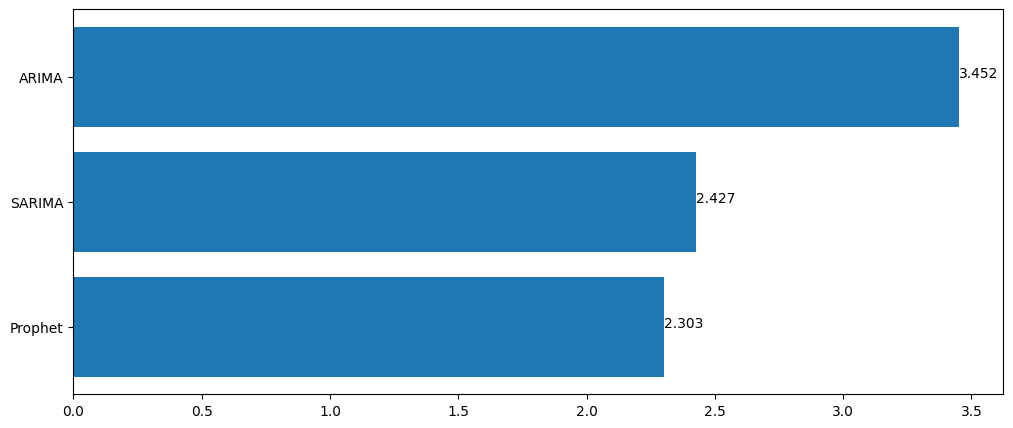

In [46]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)

for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))

plt.show()

In [50]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--
Enter a date in yyyy-mm-dd format :2023-04-30

Great! Now choose the model result you want to see for 2023-04-30
 1.Arima 
 2.Sarimax
 3.Prophet
 1
Choosen Model is Arima
In 2023-04-30 rainfall value for Arima model:  3.8521504721301825


In [48]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Rajshahi_monthly_merged.csv")